In [98]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.constants import c
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
from funcs import read_iq_bin, notch_filter, gen_chirp_to_csv_rep, spectrogram_data, extract_signals_from_bin, read_complex_csv, gen_chirp_to_csv
pulse_width = 50000
pulse_separation = 5000
B = 12.5e6

40.0


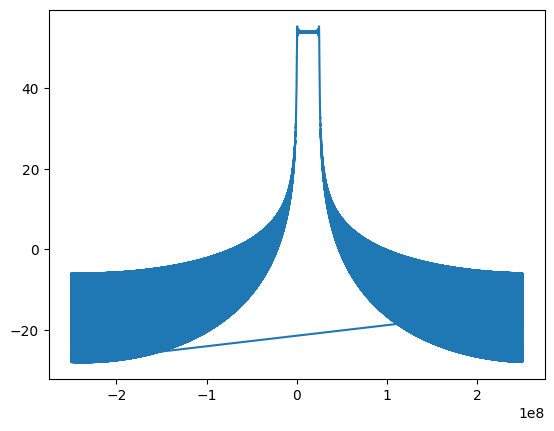

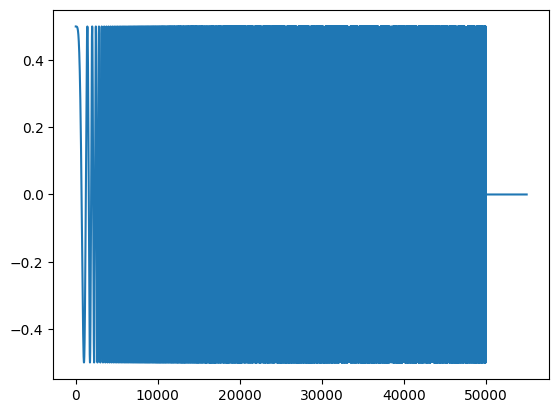

In [100]:
fs = 50e6

result = gen_chirp_to_csv_rep("../sweep.csv", 0, B, pulse_width, pulse_separation, 0.5, fs, 1)

# 3dB width delta t = 1/B
mlw = fs * 1/B
print(mlw)

fft_data = np.fft.fft(result)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)
plt.plot(fft_freq_axis, 20*np.log10(fft_data))
plt.show()

plt.plot(result)

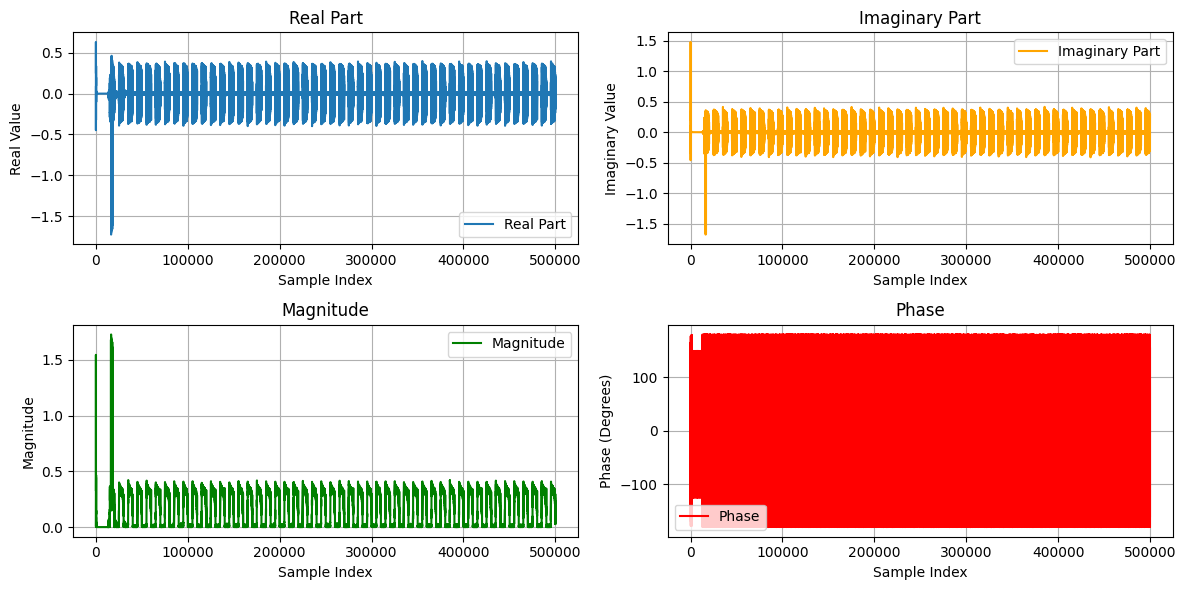

In [23]:
fs = 25e6

# Define the path to your binary file
file_path = '../outputs/pulsed_test.bin'


complex_data = read_iq_bin(file_path)
complex_data = notch_filter(complex_data, fs, 10, 0.1e6, 4)
#complex_data = median_filter_complex(complex_data,5)


# Compute magnitude and phase
magnitudes = np.abs(complex_data)
phases = np.angle(complex_data, deg=True)  # Phase in degrees

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot real part
real = np.real(complex_data)
#real = moving_average_filter(real,10)
axs[0, 0].plot(real, label='Real Part')
axs[0, 0].set_title('Real Part')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Real Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot imaginary part
axs[0, 1].plot(np.imag(complex_data), label='Imaginary Part', color='orange')
axs[0, 1].set_title('Imaginary Part')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Imaginary Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot magnitude
axs[1, 0].plot(magnitudes, label='Magnitude', color='green')
axs[1, 0].set_title('Magnitude')
axs[1, 0].set_xlabel('Sample Index')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot phase
axs[1, 1].plot(phases, label='Phase', color='red')
axs[1, 1].set_title('Phase')
axs[1, 1].set_xlabel('Sample Index')
axs[1, 1].set_ylabel('Phase (Degrees)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


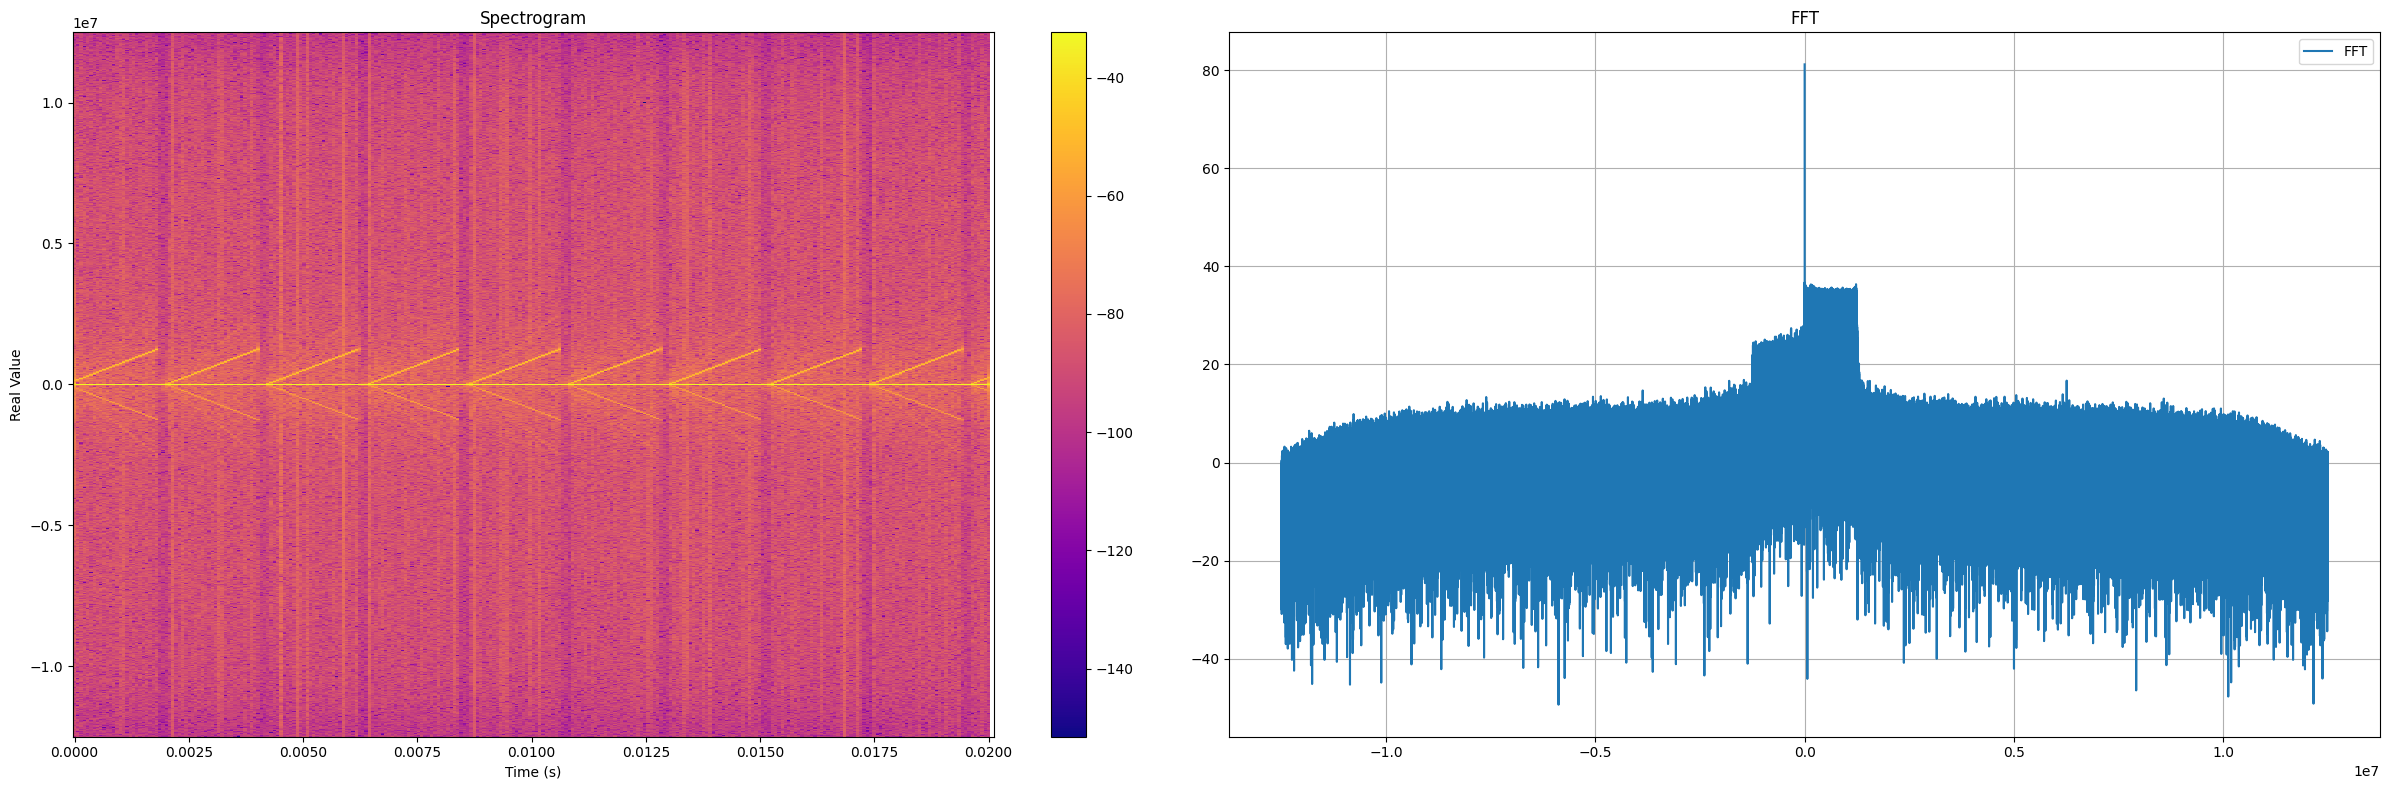

'\nplt.pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading=\'auto\', cmap=\'plasma\')\nplt.ylabel("Frequency (Hz)")\nplt.xlabel("Time (s)")\nplt.title("Spectrogram")\nplt.show()\n\nplt.plot(fft_freq_axis, magnitude_db, label=\'FFT\')\nplt.xlabel("Frequency (Hz)")\nplt.ylabel("Magnitude (dB)")\nplt.title("FFT")\nplt.show()\n'

In [102]:
file_path = '../outputs/pulsed_test.bin'
fs = 25e6


complex_data = read_iq_bin(file_path)
#complex_data = notch_filter(complex_data, fs, 10, 0.1e6, 2)
#complex_data = bandpass_filter(complex_data, 4.5e6, 7.5e6, fs, 4)

# Plotting spectrogram
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
times, frequencies_shifted, magnitude_spectrogram_db = spectrogram_data(complex_data,fs)
cax0 = axs[0].pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
#axs[0].set_colorbar(label='Magnitude (dB)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Real Value')
axs[0].set_title('Spectrogram')

# plotting fft
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
magnitude_db = 20 * np.log10(magnitude)


axs[1].plot(fft_freq_axis, magnitude_db, label='FFT')
axs[1].set_title('FFT')
axs[1].legend()
axs[1].grid(True)

fig.colorbar(cax0, ax=axs[0])
plt.tight_layout()
plt.show()
"""
plt.pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Spectrogram")
plt.show()

plt.plot(fft_freq_axis, magnitude_db, label='FFT')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("FFT")
plt.show()
"""

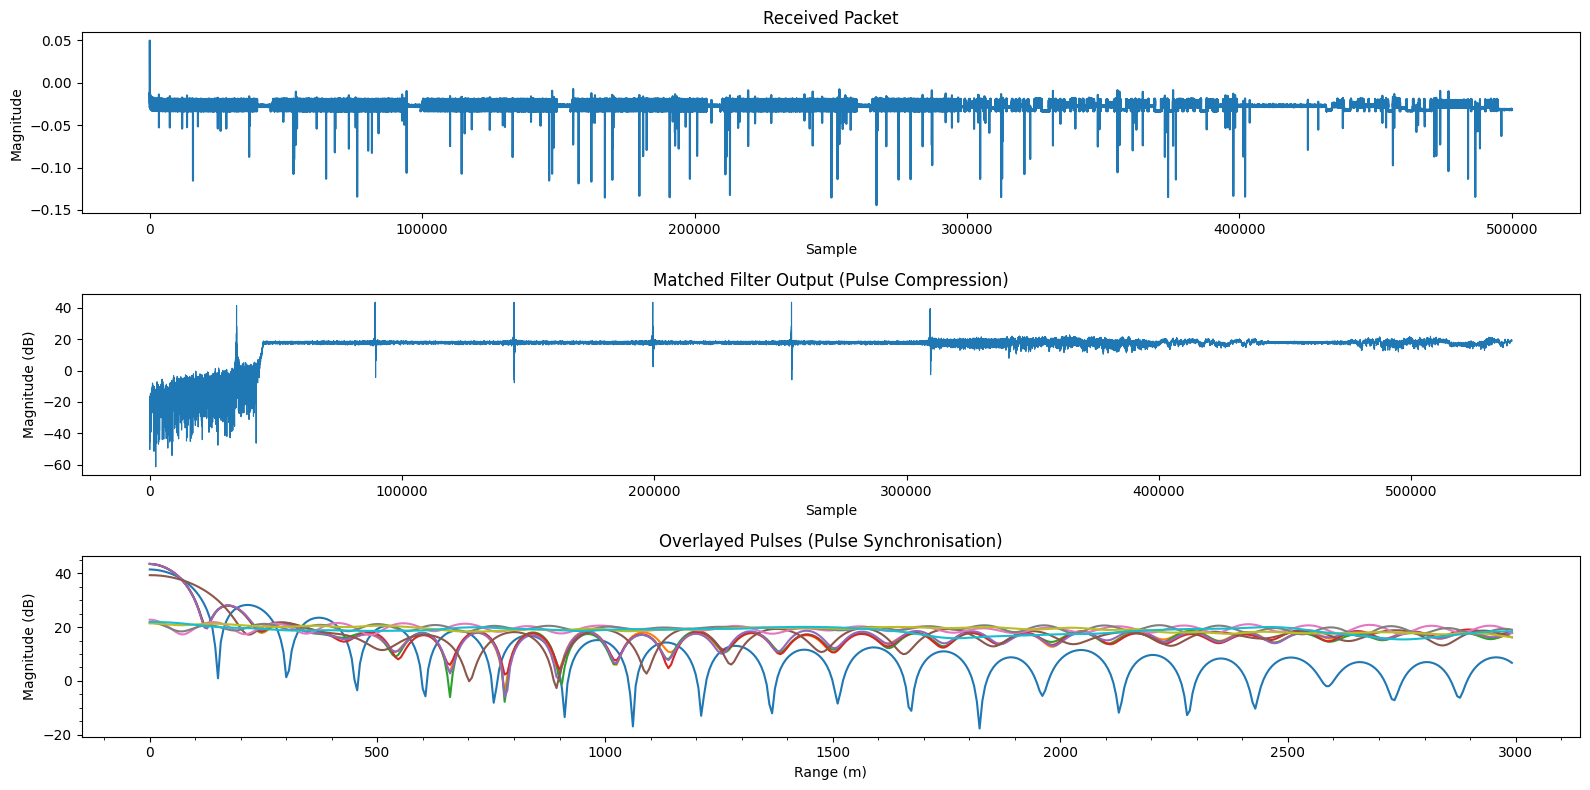

10


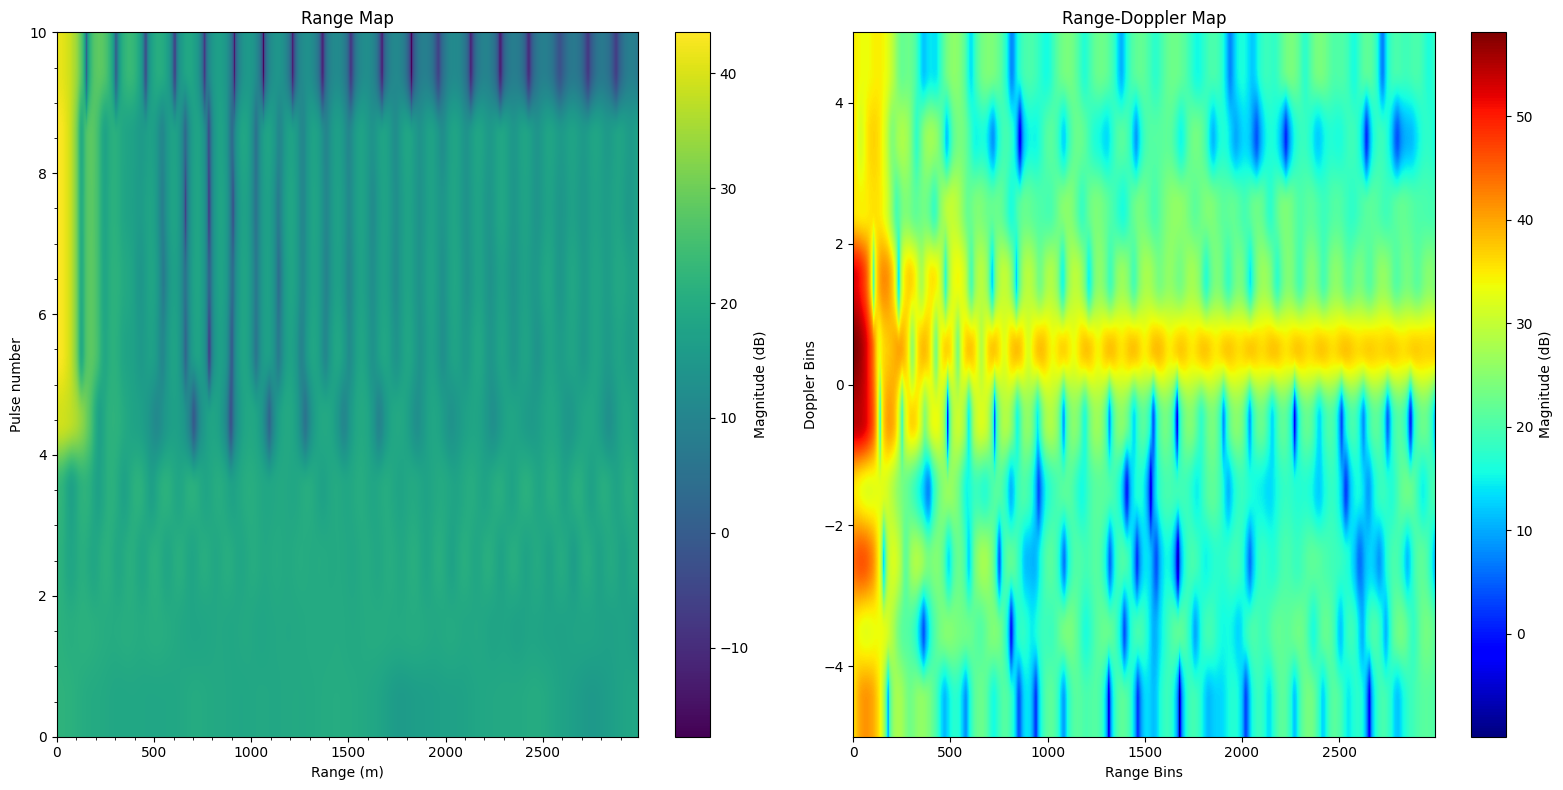

In [101]:
data = read_iq_bin("../outputs/pulsed_test.bin")
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
#data = data[50000:]

fig, axs = plt.subplots(3, 1, figsize=(16, 8))

axs[0].plot(data)
axs[0].set_title("Received Packet")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Magnitude")

# Matched filter
matched_filter = np.conjugate(template_signal[::-1])
xcorr_data = fftconvolve(data, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] # Artifact at start
axs[1].plot(20*np.log10(np.abs(xcorr_data)),linewidth=0.8)
axs[1].set_title("Matched Filter Output (Pulse Compression)")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Magnitude (dB)")

# Extract pulses
xcorr_matrix = []
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:500]
while (len(xcorr_data)>0):
    max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
    xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
    xcorr_data_plot = xcorr_data_plot[0:500]
    if (len(xcorr_data_plot)==500):
        axs[2].plot(ranges,20*np.log10(np.abs(xcorr_data_plot)))
        xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        xcorr_matrix.append(xcorr_data_plot)
    else:
        break
axs[2].minorticks_on()
axs[2].set_title("Overlayed Pulses (Pulse Synchronisation)")
axs[2].set_xlabel("Range (m)")
axs[2].set_ylabel("Magnitude (dB)")

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Range map
im_range = axs[0].imshow(20*np.log10(np.abs(xcorr_matrix)), extent=[ranges[0], ranges[-1], 0, len(xcorr_matrix)], aspect='auto', cmap='viridis') 
axs[0].minorticks_on()
axs[0].set_ylabel("Pulse number")
axs[0].set_xlabel("Range (m)")
axs[0].set_title("Range Map")


# Range-doppler
num_pulses = len(xcorr_matrix)
print(num_pulses)
num_range_bins = len(xcorr_matrix[0])

doppler_fft = np.fft.fftshift(np.fft.fft(xcorr_matrix, axis=0), axes=0)
range_doppler_map = 20 * np.log10(np.abs(doppler_fft))

im_rd = axs[1].imshow(range_doppler_map, extent=[ranges[0], ranges[-1], -num_pulses//2, num_pulses//2],
           aspect='auto', cmap='jet', origin='lower')
axs[1].set_title('Range-Doppler Map')
axs[1].set_xlabel('Range Bins')
axs[1].set_ylabel('Doppler Bins')

cbar = plt.colorbar(im_range, ax=axs[0])
cbar.set_label('Magnitude (dB)')  # Set the label for the colorbar
cbar = plt.colorbar(im_rd, ax=axs[1])
cbar.set_label('Magnitude (dB)')  # Set the label for the colorbar
plt.tight_layout()
plt.show()

In [ ]:
data_matrix = extract_signals_from_bin("../outputs/signal.bin", 500)
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
#data = data[50000:]

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

axs[0].plot(data)
axs[0].set_title("Received Packet")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Magnitude")


# Extract pulses
xcorr_matrix = []
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:500]
for signal in data_matrix:
    axs[1].plot(ranges,20*np.log10(np.abs(signal)))
axs[1].minorticks_on()
axs[1].set_title("Overlayed Pulses (Pulse Synchronisation)")
axs[1].set_xlabel("Range (m)")
axs[1].set_ylabel("Magnitude (dB)")

plt.tight_layout()
plt.show()

# Range map
plt.figure(figsize=(10,10))
plt.imshow(20*np.log10(np.abs(data_matrix)), extent=[ranges[0], ranges[-1], 0, len(data_matrix)], aspect='auto', cmap='viridis') 
plt.minorticks_on()
plt.colorbar()  
plt.ylabel("Pulse number")
plt.xlabel("Range (m)")
plt.title("Range Map")
plt.show()

# Range-doppler
num_pulses = len(data_matrix)
print(num_pulses)
num_range_bins = len(data_matrix[0])

doppler_fft = np.fft.fftshift(np.fft.fft(data_matrix, axis=0), axes=0)
range_doppler_map = 20 * np.log10(np.abs(doppler_fft))
plt.figure(figsize=(10,10))
plt.imshow(range_doppler_map, extent=[ranges[0], ranges[-1], -num_pulses//2, num_pulses//2],
           aspect='auto', cmap='jet', origin='lower')
plt.title('Range-Doppler Map')
plt.xlabel('Range Bins')
plt.ylabel('Doppler Bins')
plt.colorbar(label='Magnitude (dB)')
plt.show()

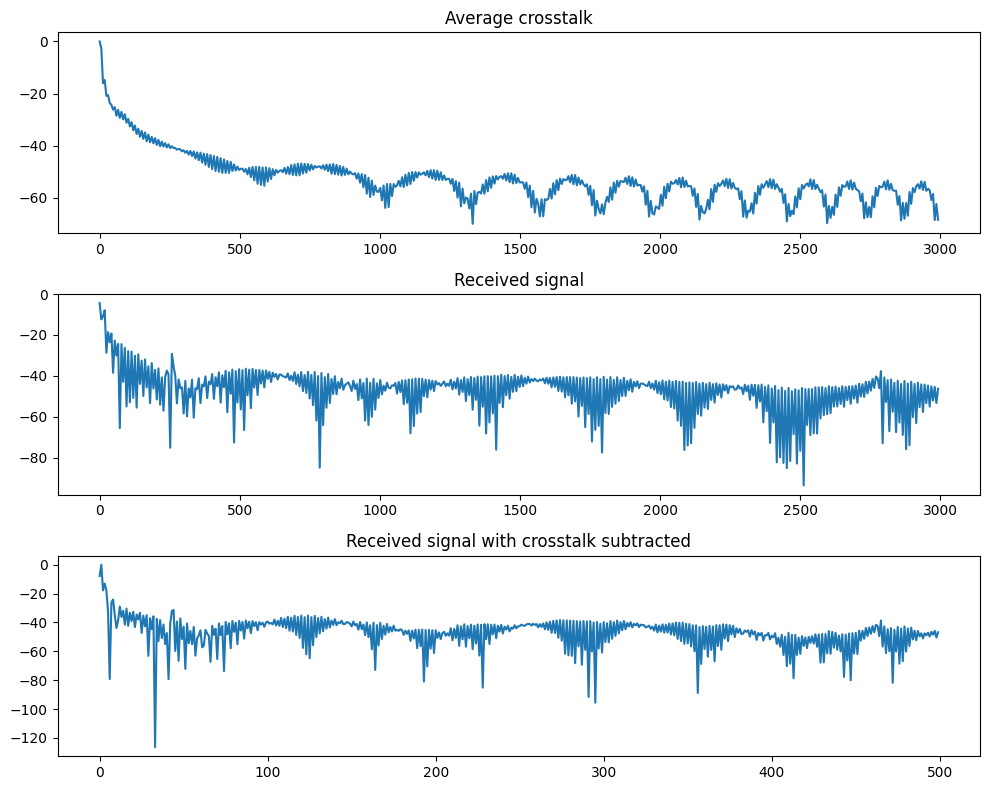

In [7]:
fs = 25e6


fig, axs = plt.subplots(3, 1, figsize=(10, 8))

crosstalk_mat = extract_signals_from_bin("../outputs/crosstalk.bin", 500)
average_signal = np.mean(crosstalk_mat, axis=0)
ranges = np.arange(len(average_signal)) * c / (2*25e6)
#average_signal = crosstalk_mat[0]
max_val = np.max(np.abs(average_signal))
axs[0].plot(ranges,20*np.log10(np.abs(average_signal)/max_val))
axs[0].set_title("Average crosstalk")

pulsed_mat = extract_signals_from_bin("../outputs/signal.bin", 500)
data = np.mean(pulsed_mat, axis=0)

axs[1].plot(ranges,20*np.log10(np.abs(data)/max_val))
axs[1].set_title("Received signal")


diff = data - average_signal
ranges = 3e8*np.arange(len(diff))/25e6
max_val = np.max(np.abs(diff))
axs[2].plot(20*np.log10(np.abs(diff)/max_val))
axs[2].set_title("Received signal with crosstalk subtracted")


plt.tight_layout()
plt.show()



In [ ]:
fs = 25e6

crosstalk_mat = extract_signals_from_bin("../outputs/crosstalk.bin", 500)
average_crosstalk = np.mean(crosstalk_mat, axis=0)
max_val = np.max(np.abs(average_crosstalk))

pulsed_mat = extract_signals_from_bin("../outputs/signal.bin", 500)
data = np.mean(pulsed_mat, axis=0)

diff = data - average_crosstalk

correlation = np.correlate(data, average_crosstalk, mode='full')
max_idx = np.argmax(correlation)
correlation = correlation[max_idx:]
corr_db = 20*np.log10(np.abs(correlation))
max_idx = np.argmax(correlation)
d = c*max_idx/fs
ranges = np.arange(len(correlation)) * c / (2*25e6)

# Compute Pearson correlation coefficient
correlation_matrix = np.corrcoef(diff, average_crosstalk)
correlation_coefficient = correlation_matrix[0, 1]
print("Correlation Coefficient (diff and crosstalk):", correlation_coefficient)
correlation_matrix = np.corrcoef(data, average_crosstalk)
correlation_coefficient = correlation_matrix[0, 1]
print("Correlation Coefficient (recv and crosstalk):", correlation_coefficient)

plt.figure(figsize=(10,8))
plt.plot(corr_db)
plt.xlabel("Positive lags")
plt.ylabel("Magnitude (dB)")
plt.title("Cross-Correlation")
plt.show()

In [ ]:
fs = 25e6


fig, axs = plt.subplots(1, 1, figsize=(10, 8))

crosstalk_mat = extract_signals_from_bin("../outputs/crosstalk.bin", 500)
average_signal = np.mean(crosstalk_mat, axis=0)
ranges = np.arange(len(average_signal)) * c / (2*fs)
#average_signal = crosstalk_mat[0]
max_val = np.max(np.abs(average_signal))
axs.plot(ranges,20*np.log10(np.abs(average_signal)/max_val), label="Averaged crosstalk")
axs.set_title("Average crosstalk")

pulsed_mat = extract_signals_from_bin("../outputs/signal.bin", 500)
data = np.mean(pulsed_mat, axis=0)
template_signal = read_complex_csv("../sweep.csv")
pulse_width = 500
template_signal = template_signal[0:pulse_width]

axs.plot(ranges,20*np.log10(np.abs(data)/max_val), label="Received Signal")
axs.set_title("Received signal")


diff = data - average_signal

#max_val = np.max(np.abs(diff))
axs.plot(ranges,20*np.log10(np.abs(diff)/max_val), label="Difference")
axs.set_title("Received signal with crosstalk subtracted")
axs.set_xlabel("Range (m)")
axs.set_ylabel("Magnitude (dB)")
axs.legend()


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(ranges,20*np.log10(np.abs(diff)/max_val), color="green")
plt.xlabel("Range (m)")
plt.ylabel("Magnitude (dB)")
plt.title("Received signal with crosstalk subtracted")
plt.show()


In [ ]:
fs = 25e6
B = 12e6
mlw = fs * 2 * 1/B
print(f"Main lobe width: {mlw}")


crosstalk_mat = extract_signals_from_bin("../outputs/crosstalk.bin", 500)
average_signal = np.mean(crosstalk_mat, axis=0)
ranges = np.arange(len(average_signal)) * c / (2*25e6)
#average_signal = crosstalk_mat[0]
max_val = np.max(np.abs(average_signal))

pulsed_mat = extract_signals_from_bin("../outputs/signal.bin", 500)
data = np.mean(pulsed_mat, axis=0)
template_signal = read_complex_csv("../sweep.csv")
pulse_width = 500
template_signal = template_signal[0:pulse_width]


diff = data - average_signal
# Shift by MLW
diff = diff[int(mlw):]
ranges = ranges[int(mlw):]

plt.figure(figsize=(10, 8))
plt.plot(ranges,20*np.log10(np.abs(diff)/max_val), color="green")
plt.xlabel("Range (m)")
plt.ylabel("Magnitude (dB)")
plt.title("Received signal with crosstalk subtracted")
plt.show()


In [ ]:
fs = 25e6


fig, axs = plt.subplots(3, 1, figsize=(10, 8))

crosstalk_mat = extract_signals_from_bin("outputs/crosstalk.bin", 500)
average_signal = np.mean(crosstalk_mat, axis=0)
#average_signal = crosstalk_mat[0]
max_val = np.max(np.abs(average_signal))
axs[0].plot(20*np.log10(np.abs(average_signal)))
axs[0].set_ylabel("Magnitude (dB)")
axs[0].set_title("Average crosstalk")

data_no_cable = read_iq_bin("outputs/pulsed_test_no_cable.bin")
data_cable = read_iq_bin("outputs/pulsed_test_cable.bin")
template_signal = read_complex_csv("sweep.csv")
pulse_width = 500
template_signal = template_signal[0:pulse_width]

matched_filter = np.conjugate(template_signal[::-1])
xcorr_data_no_cable = fftconvolve(data_no_cable, matched_filter, mode='full')
xcorr_data_cable = fftconvolve(data_cable, matched_filter, mode='full')

#xcorr_data = xcorr_data[5000:-5000] # Artifact at start
#xcorr_data = xcorr_data[0:2500]
max_idx_no_cable = np.argmax(np.abs(xcorr_data_no_cable))
xcorr_data_no_cable = xcorr_data_no_cable[max_idx_no_cable:max_idx_no_cable+500]
max_idx_cable = np.argmax(np.abs(xcorr_data_cable))
xcorr_data_cable = xcorr_data_cable[max_idx_cable:max_idx_cable+500]
max_val = np.max(np.abs(xcorr_data))
axs[1].plot(20*np.log10(np.abs(xcorr_data_no_cable)), label="No cable")
axs[1].plot(20*np.log10(np.abs(xcorr_data_cable)), label="Cable")
axs[1].set_ylabel("Magnitude (dB)")
axs[1].set_title("Received signal")
axs[1].legend()

diff_nc = xcorr_data_no_cable - average_signal
diff_c = xcorr_data_cable - average_signal
axs[2].plot(20*np.log10(np.abs(diff_nc)), label="No cabel")
axs[2].plot(20*np.log10(np.abs(diff_c)), label="Cabel")
axs[2].set_ylabel("Magnitude (dB)")
axs[2].set_title("Received signal with crosstalk subtracted")
axs[2].legend()


plt.tight_layout()
plt.show()



# FMCW

45977
expected f_beat=5211.938987471126
d=9.379734718707047


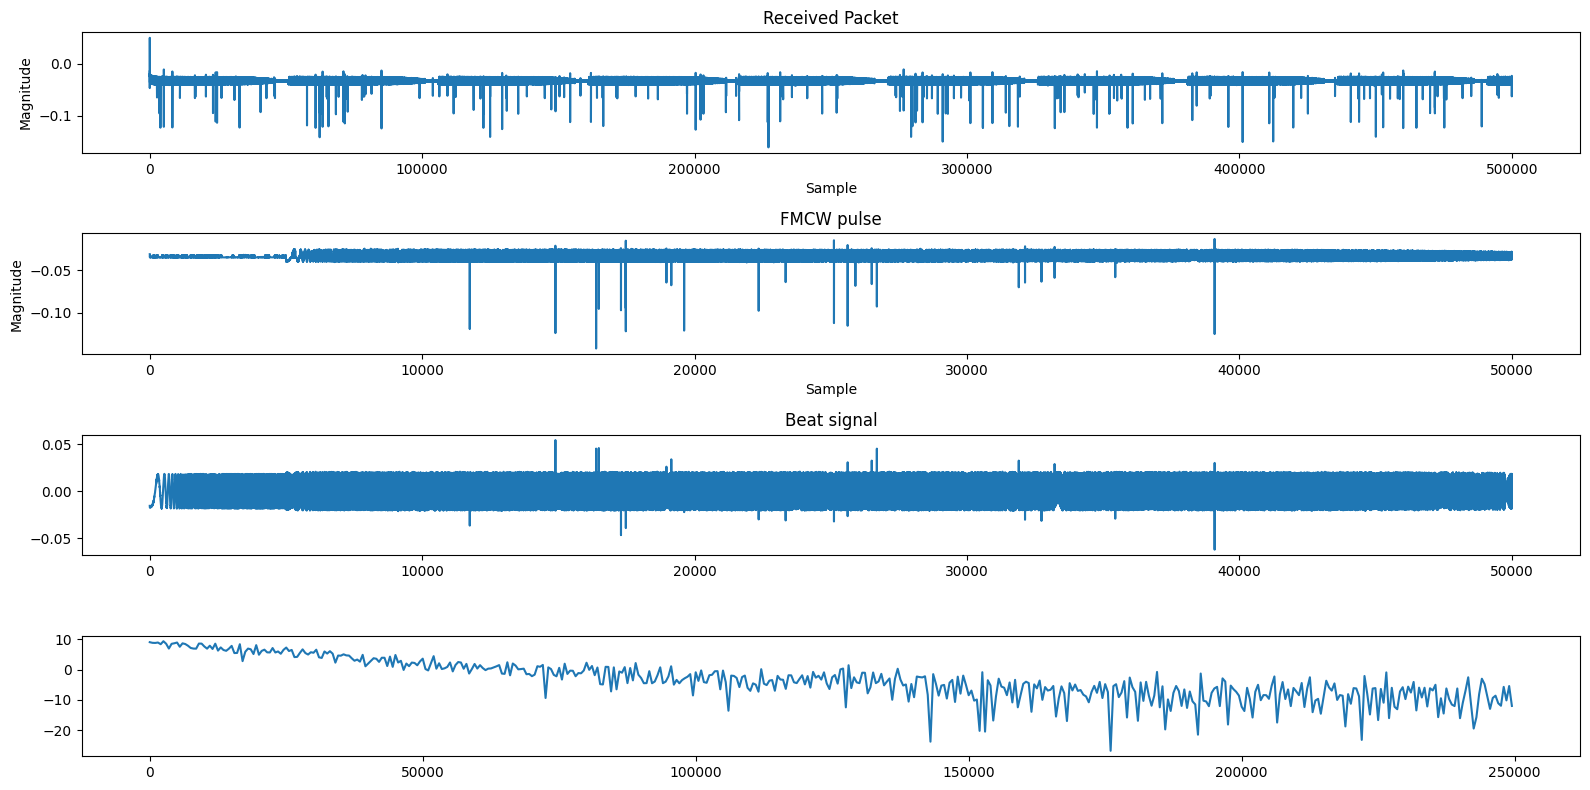

In [93]:
fs = 25e6

data = read_iq_bin("../outputs/pulsed_test.bin")
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
#data = data[50000:]

fig, axs = plt.subplots(4, 1, figsize=(16, 8))

axs[0].plot(data)
axs[0].set_title("Received Packet")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Magnitude")

# Matched filter
matched_filter = np.conjugate(template_signal[::-1])
xcorr_data = fftconvolve(data, matched_filter, mode='full')
# First max index to see where CW has started
max_idx = np.argmax(xcorr_data[:pulse_width +pulse_separation])
print(max_idx)
axs[1].plot(data[max_idx:max_idx+pulse_width])
axs[1].set_title("FMCW pulse")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Magnitude")

# Beat signal
extracted = data[max_idx:max_idx+pulse_width]
beat_signal = extracted * np.conj(template_signal) 
axs[2].plot(beat_signal)
axs[2].set_title("Beat signal")


# FFT for beat frequency
fft_data = np.fft.fft(beat_signal)
fft_freqs = np.fft.fftfreq(len(beat_signal),1/fs)
fft_db = 20*np.log10(np.abs(fft_data))
#axs[3].plot(fft_freqs,fft_db)

midpt = len(fft_freqs)//2
end_idx = 500
fft_freqs = fft_freqs[:-midpt]
fft_db = fft_db[:-midpt]
fft_freqs = fft_freqs[:end_idx]
fft_db = fft_db[:end_idx]
axs[3].plot(fft_freqs,fft_db)

dF = B
T = pulse_width/fs
K = dF/T
d = 125
f_beat = K * 2*d/c
print(f"expected f_beat={f_beat}")


dR = c/(2*B)
max_idx = np.argmax(fft_db)
d = fft_db[max_idx]
print(f"d={d}")


plt.tight_layout()
plt.show()